In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline 
sns.set(style="ticks")

**1. Загрузка данных**

In [8]:
data_raw = pd.read_csv('breast_cancer.csv', sep=";")

**2.1 Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных**

In [9]:
data_raw.dtypes

diagnosis              int64
radius               float64
texture              float64
perimeter            float64
area                 float64
smoothness           float64
compactness          float64
concavity            float64
concave points       float64
symmetry             float64
fractal_dimension    float64
dtype: object

In [10]:
data_raw.head()

diagnosis  radius  texture  perimeter    area  smoothness  compactness  \
0          1   17.99    10.38     122.80  1001.0     0.11840      0.27760   
1          1   20.57    17.77     132.90  1326.0     0.08474      0.07864   
2          1   19.69    21.25     130.00  1203.0     0.10960      0.15990   
3          1   11.42    20.38      77.58   386.1     0.14250      0.28390   
4          1   20.29    14.34     135.10  1297.0     0.10030      0.13280   

   concavity  concave points  symmetry  fractal_dimension  
0     0.3001         0.14710    0.2419            0.07871  
1     0.0869         0.07017    0.1812            0.05667  
2     0.1974         0.12790    0.2069            0.05999  
3     0.2414         0.10520    0.2597            0.09744  
4     0.1980         0.10430    0.1809            0.05883

In [11]:
data_raw.isnull().sum()

diagnosis            0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
concavity            0
concave points       0
symmetry             0
fractal_dimension    0
dtype: int64

In [12]:
data_raw.shape

(569, 11)

In [13]:
data = data_raw.drop_duplicates()
data.shape

(569, 11)

Вывод. Изначальный датасет не содержит дубликатов и пропусков.

**2.2 Построение графиков для понимания структуры данных**

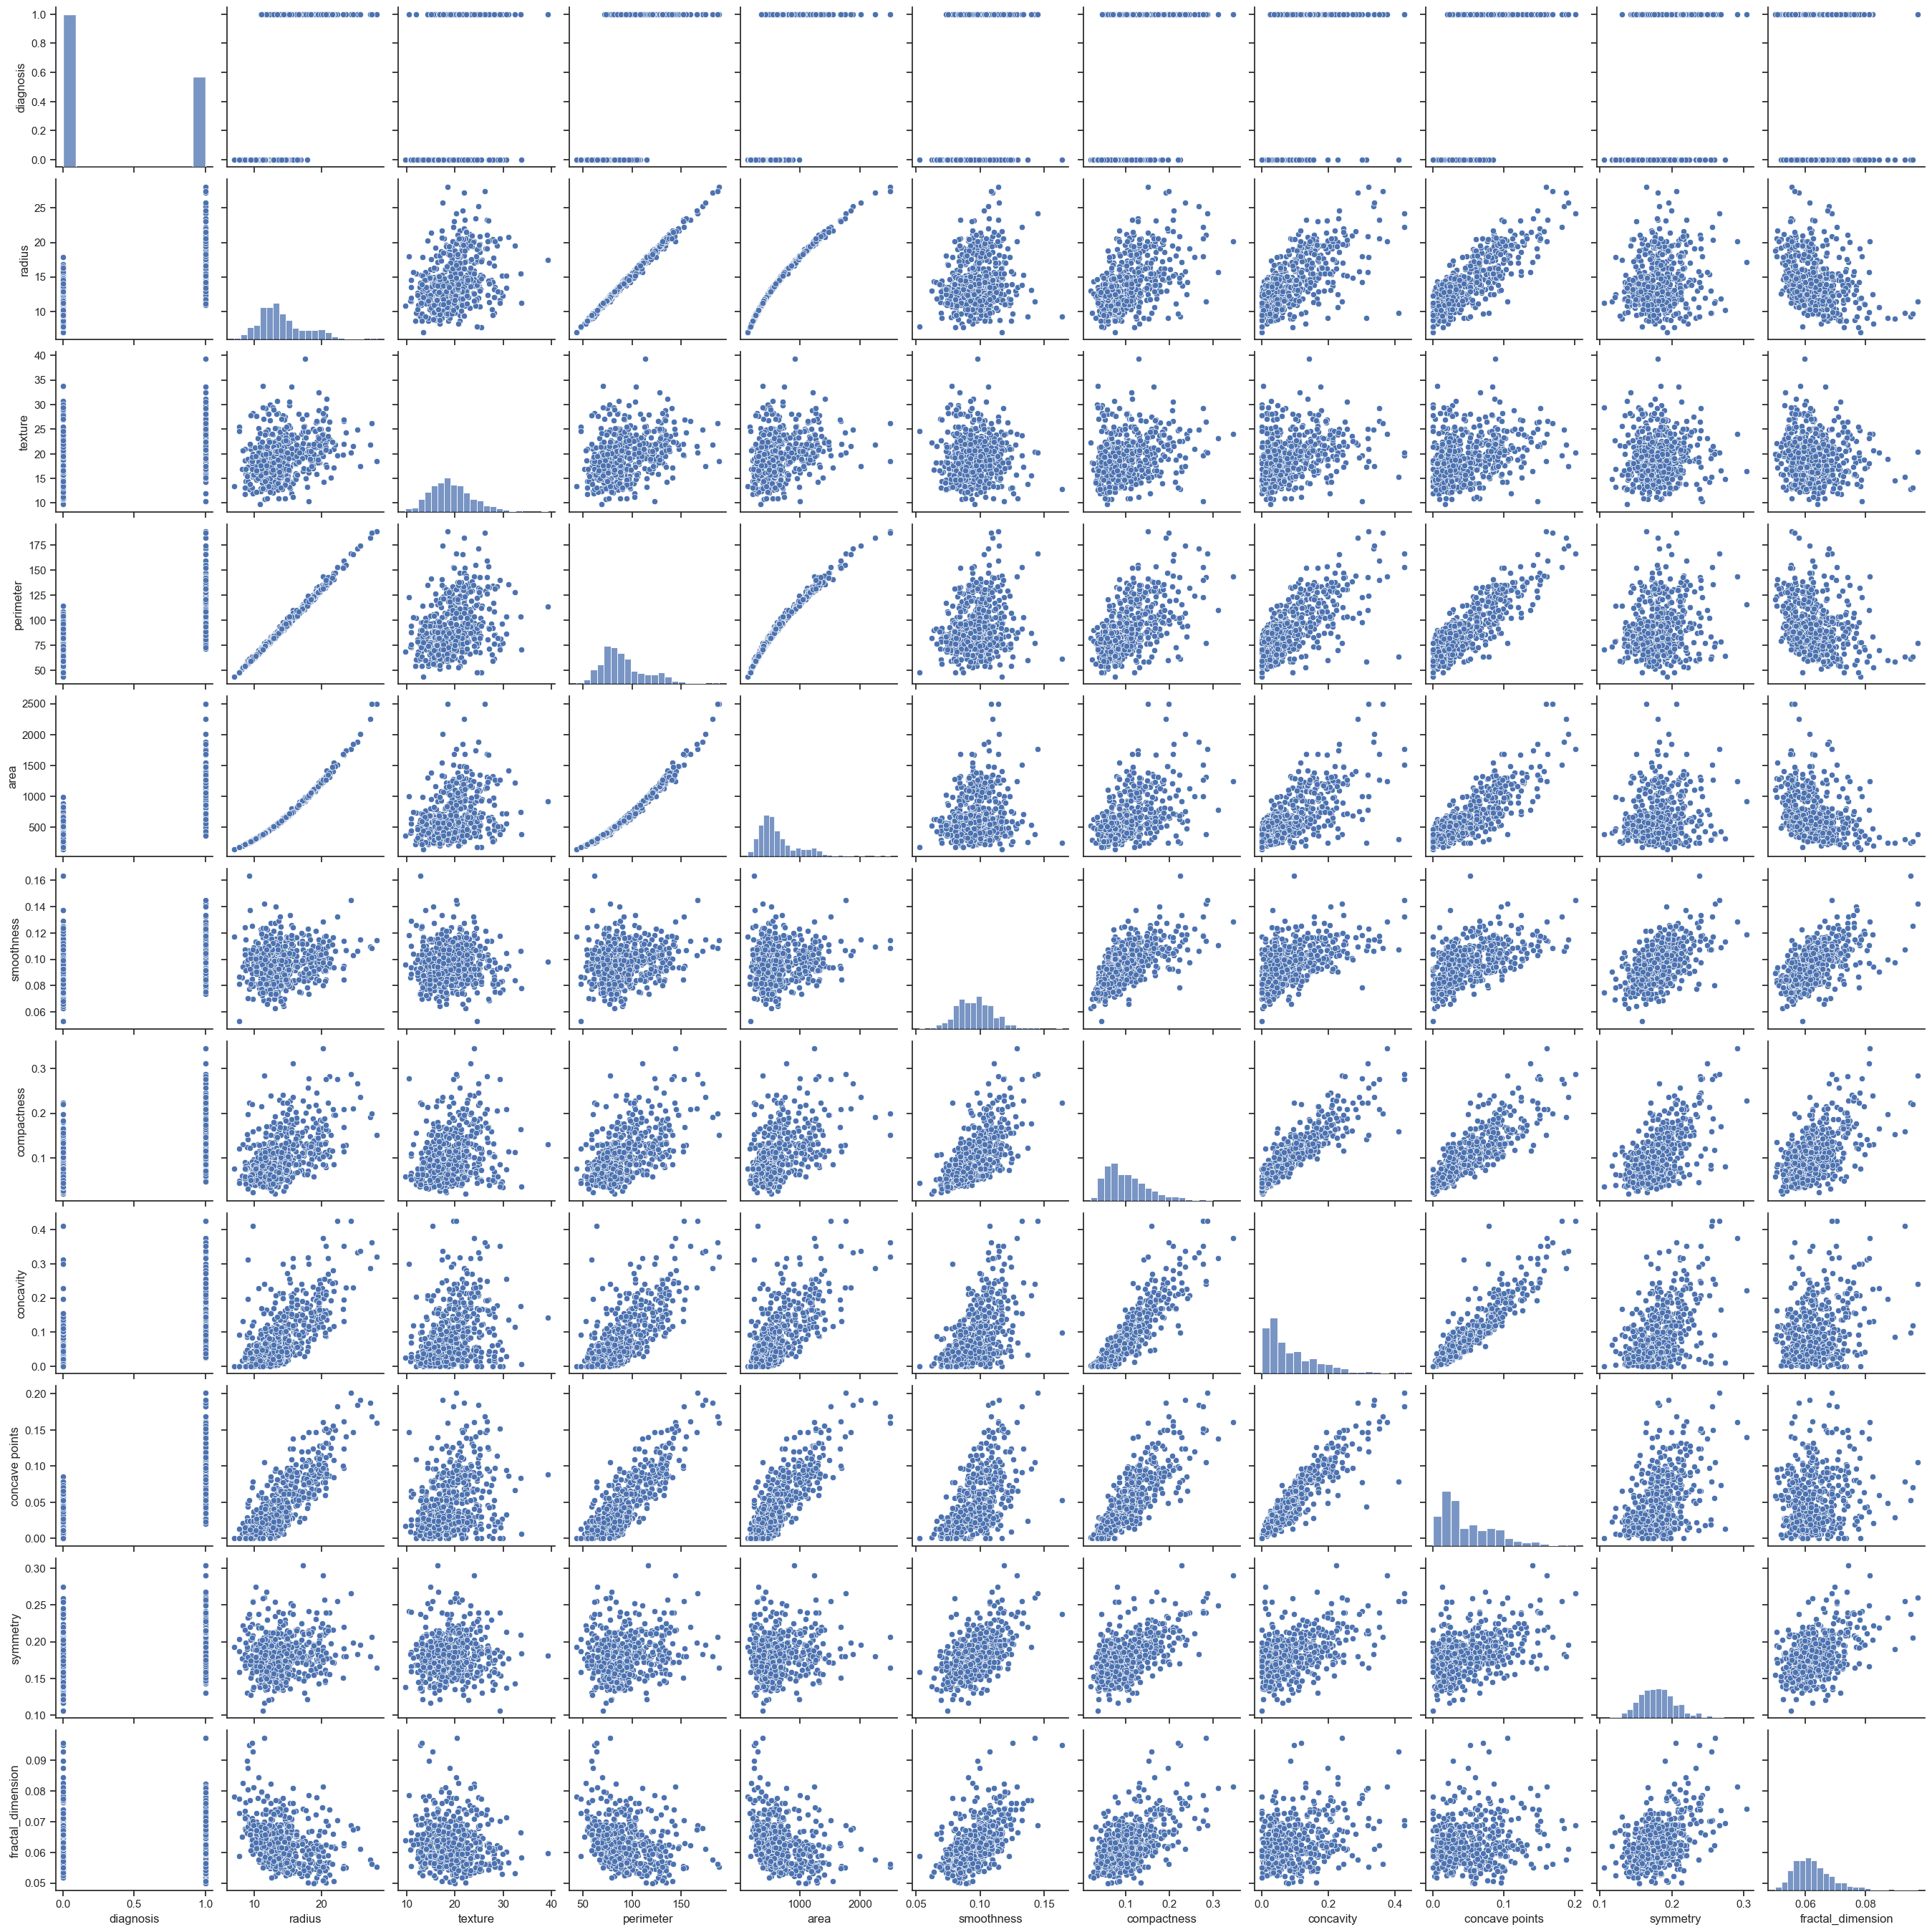

In [14]:
# Парные диаграммы
sns.pairplot(data)

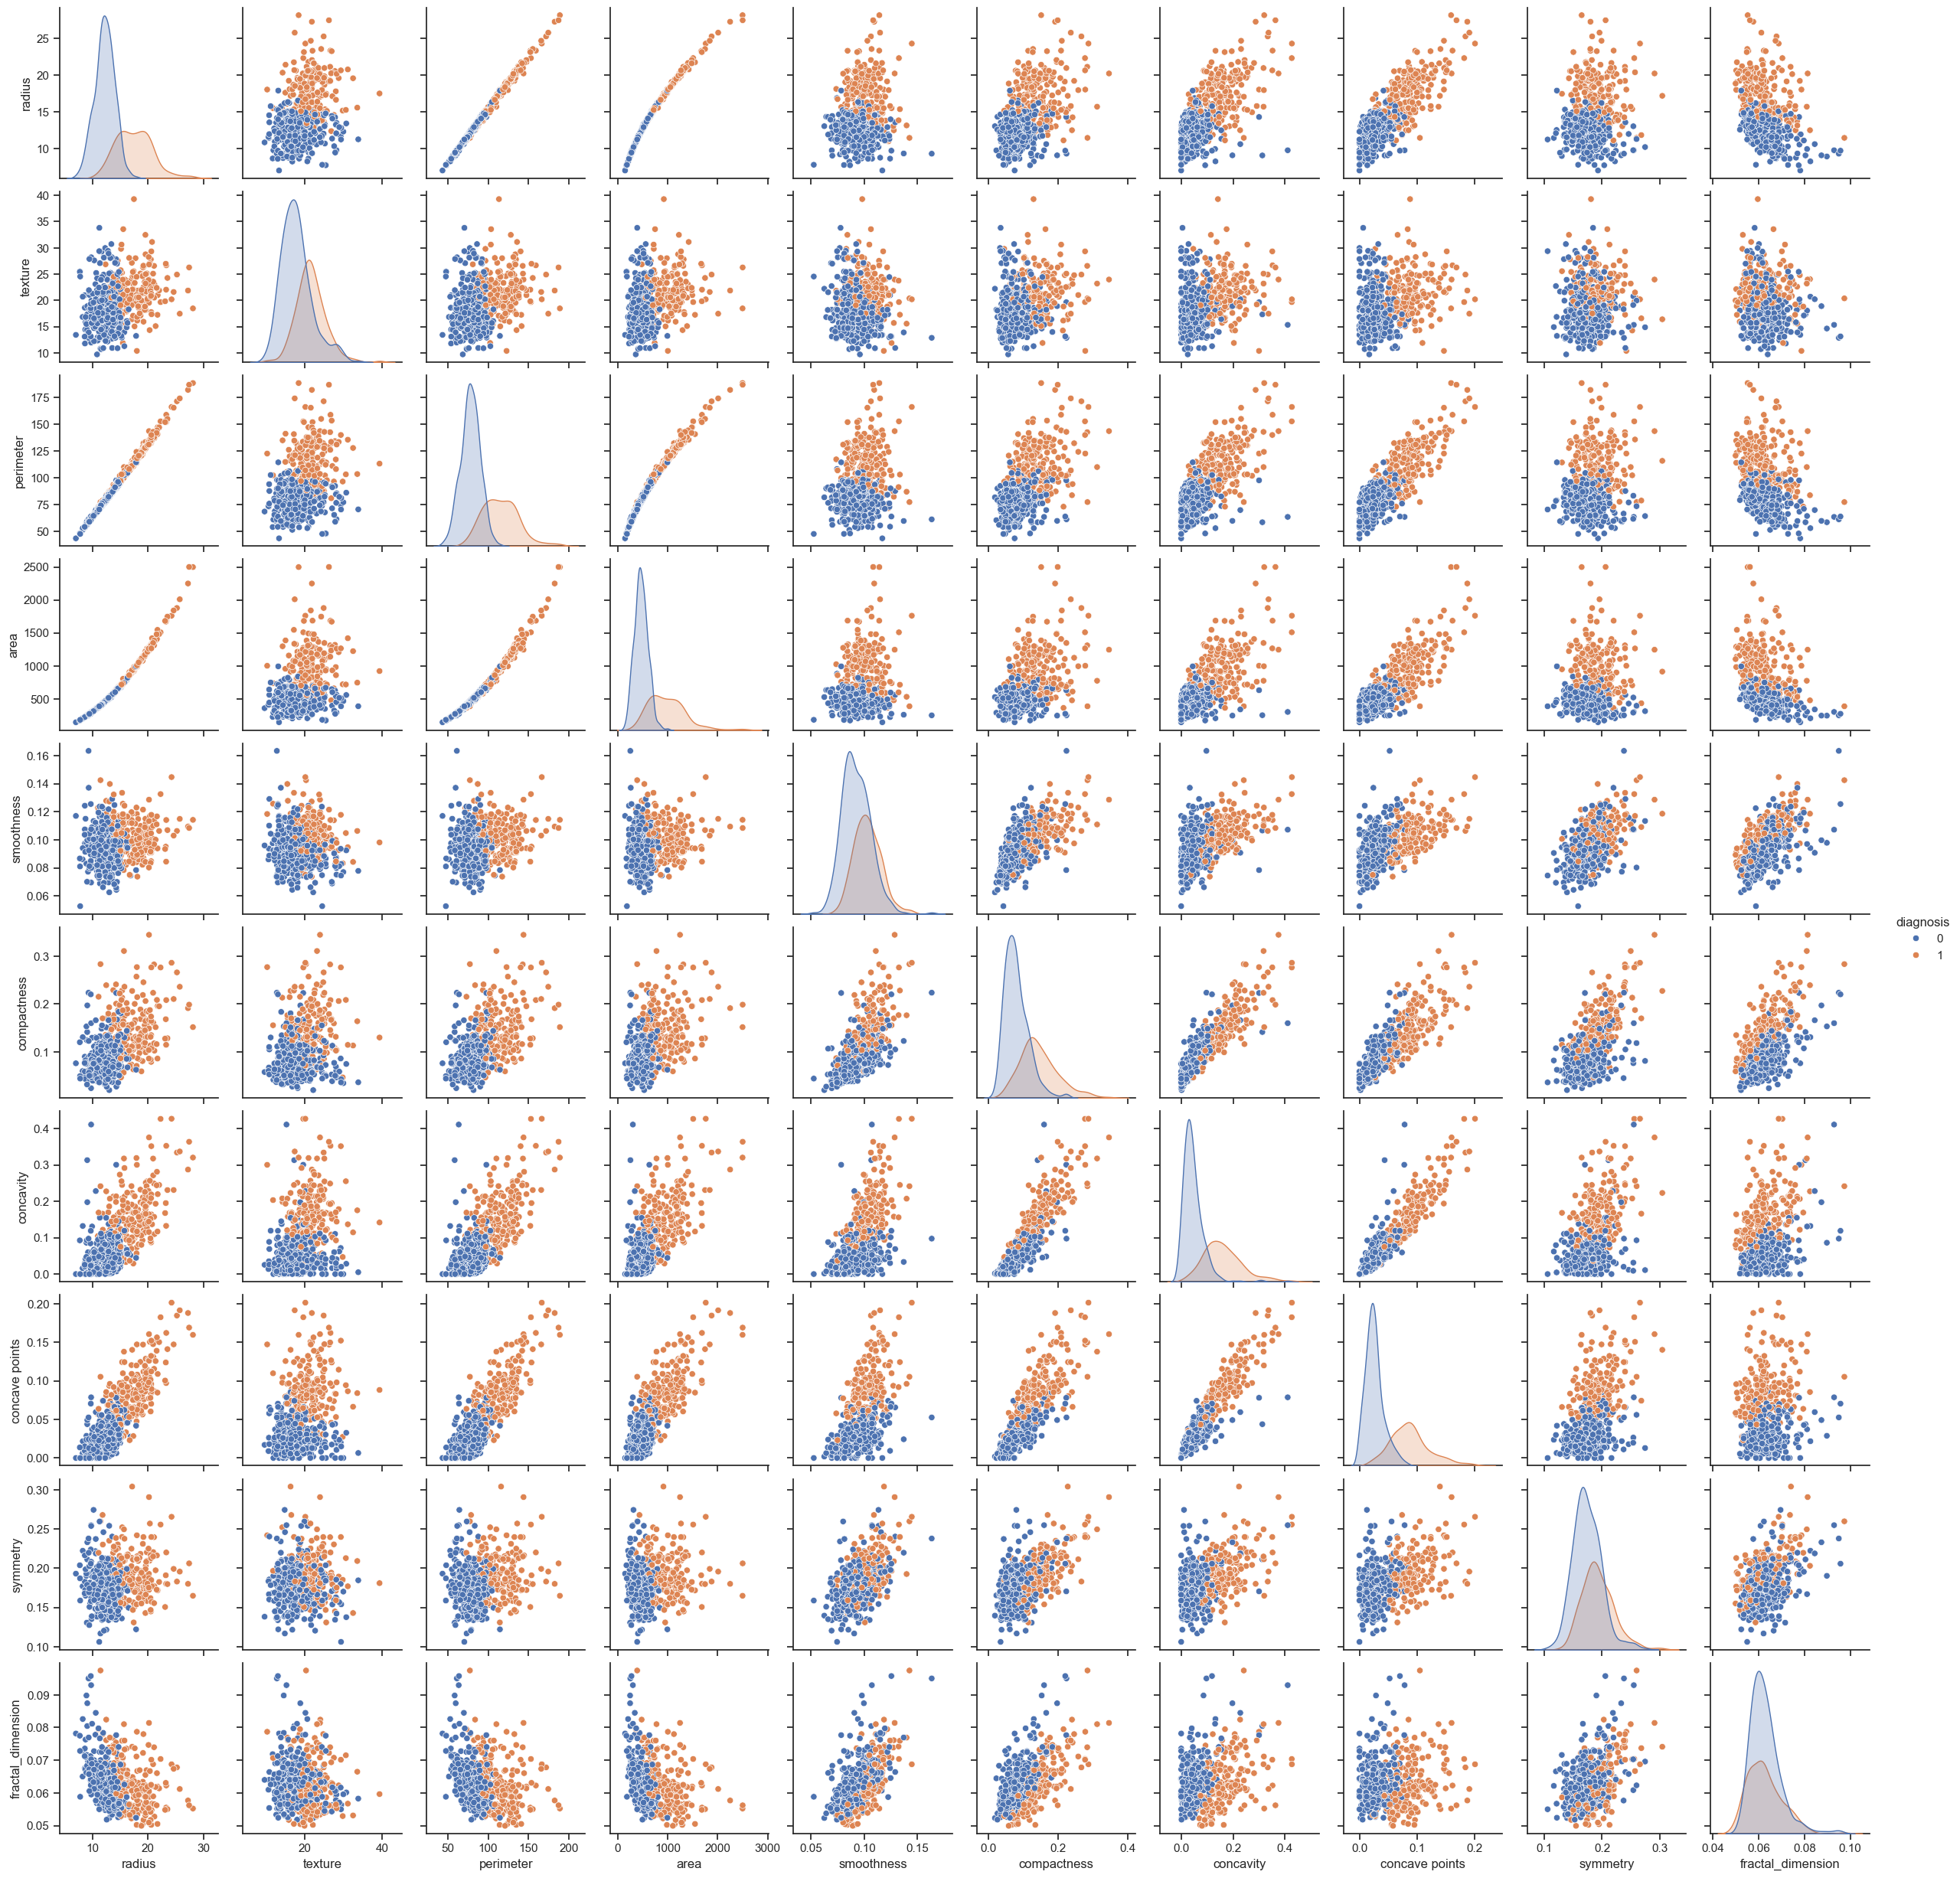

In [15]:
sns.pairplot(data, hue="diagnosis")

In [16]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только 0 и 1
data['diagnosis'].unique()

array([1, 0], dtype=int64)

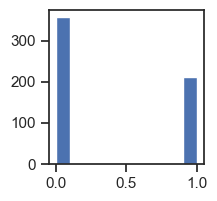

In [17]:
# Оценим дисбаланс классов для Occupancy
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(data['diagnosis'])
plt.show()

In [18]:
data['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [19]:
# посчитаем дисбаланс классов
total = data.shape[0]
class_0, class_1 = data['diagnosis'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 62.739999999999995%, а класс 1 составляет 37.26%.


Вывод: дисбаланс классов присутсвутет, но является приемлемым.

In [20]:
data.columns

Index(['diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness',
       'compactness', 'concavity', 'concave points', 'symmetry',
       'fractal_dimension'],
      dtype='object')

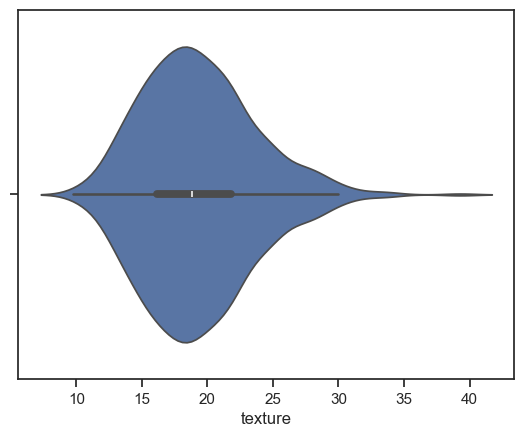

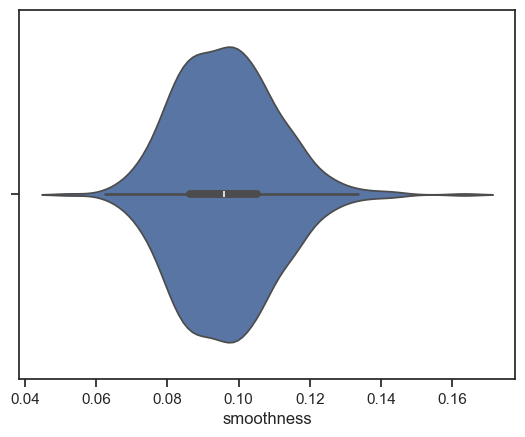

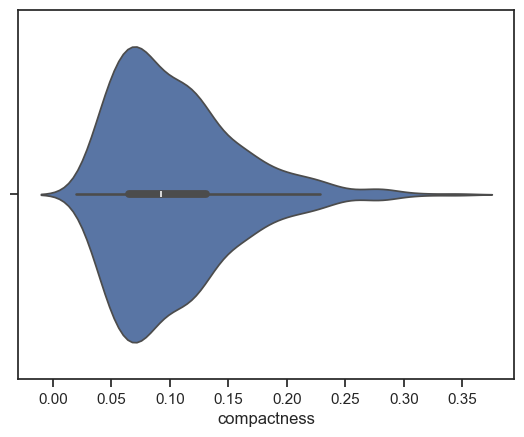

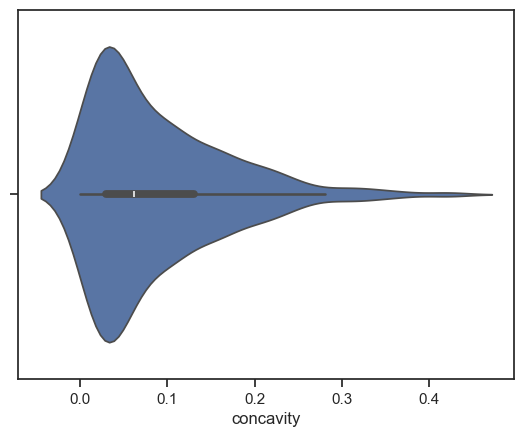

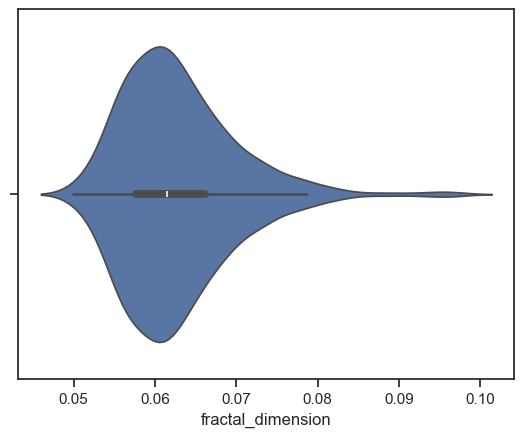

In [21]:
# Скрипичные диаграммы для некоторых числовых колонок
for col in ['texture', 'smoothness', 'compactness', 'concavity', 'fractal_dimension']:
    sns.violinplot(x=data[col])
    plt.show()

**3. Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.**

Для построения моделей будем использовать все признаки.

Категориальные признаки отсутствуют, их кодирования не требуется. Исключением является признак Diagnosis, но в представленном датасете он уже закодирован на основе подхода LabelEncoding.

Вспомогательные признаки для улучшения качества моделей в данном примере мы строить не будем.

Выполним масштабирование данных

In [22]:
# Числовые колонки для масштабирования
scale_cols = [ 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal_dimension']

In [23]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [24]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc1_data[:,i]

In [25]:
data.head()

diagnosis  radius  texture  perimeter    area  smoothness  compactness  \
0          1   17.99    10.38     122.80  1001.0     0.11840      0.27760   
1          1   20.57    17.77     132.90  1326.0     0.08474      0.07864   
2          1   19.69    21.25     130.00  1203.0     0.10960      0.15990   
3          1   11.42    20.38      77.58   386.1     0.14250      0.28390   
4          1   20.29    14.34     135.10  1297.0     0.10030      0.13280   

   concavity  concave points  symmetry  ...  radius_scaled  texture_scaled  \
0     0.3001         0.14710    0.2419  ...       0.521037        0.022658   
1     0.0869         0.07017    0.1812  ...       0.643144        0.272574   
2     0.1974         0.12790    0.2069  ...       0.601496        0.390260   
3     0.2414         0.10520    0.2597  ...       0.210090        0.360839   
4     0.1980         0.10430    0.1809  ...       0.629893        0.156578   

   perimeter_scaled  area_scaled  smoothness_scaled  compactness_scaled  \
0          0.545989     0.363733           0.593753            0.792037   
1          0.615783     0.501591           0.289880            0.181768   
2          0.595743     0.449417           0.514309            0.431017   
3          0.233501     0.102906           0.811321            0.811361   
4          0.630986     0.489290           0.430351            0.347893   

   concavity_scaled  concave points_scaled  symmetry_scaled  \
0          0.703140               0.731113         0.686364   
1          0.203608               0.348757         0.379798   
2          0.462512               0.635686         0.509596   
3          0.565604               0.522863         0.776263   
4          0.463918               0.518390         0.378283   

   fractal_dimension_scaled  
0                  0.605518  
1                  0.141323  
2                  0.211247  
3                  1.000000  
4                  0.186816  

[5 rows x 21 columns]

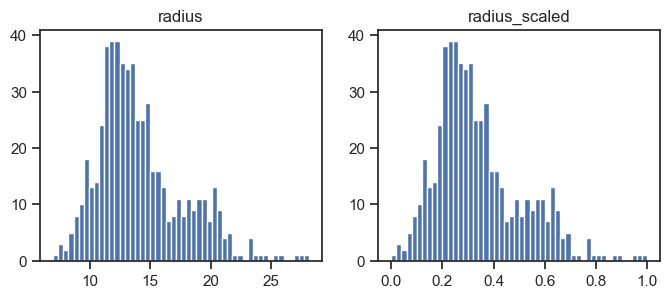

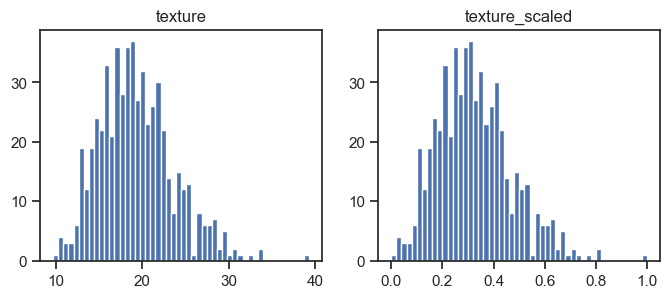

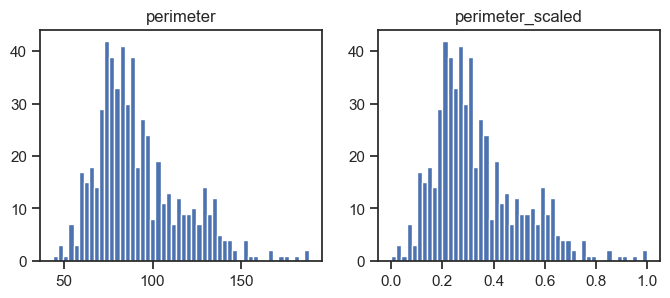

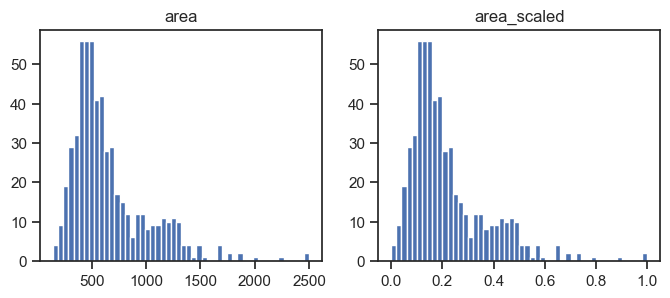

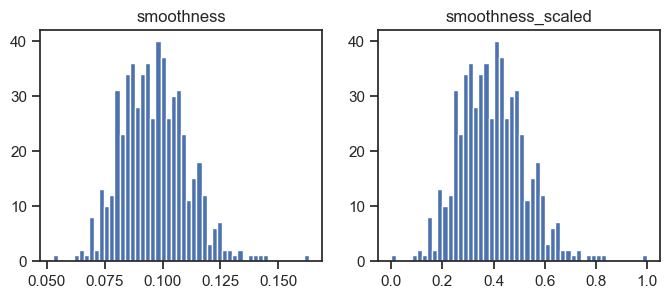

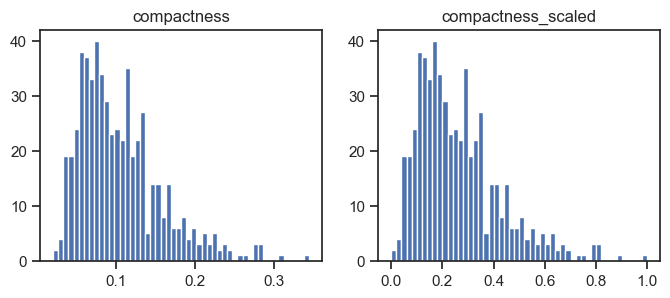

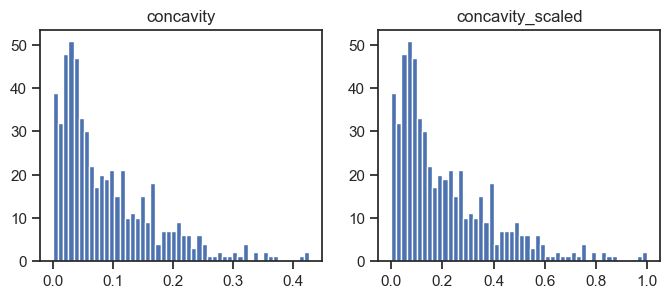

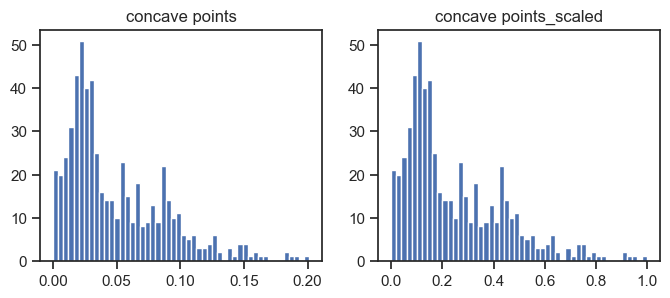

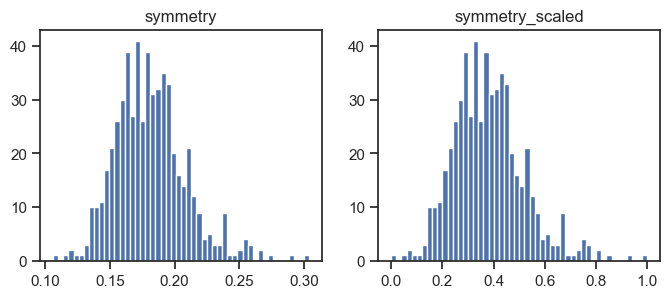

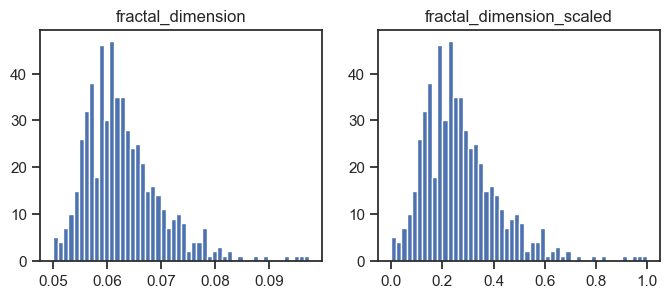

In [26]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

**4. Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.**

In [27]:
corr_cols_1 = scale_cols + ['diagnosis']
corr_cols_1

['radius',
 'texture',
 'perimeter',
 'area',
 'smoothness',
 'compactness',
 'concavity',
 'concave points',
 'symmetry',
 'fractal_dimension',
 'diagnosis']

In [28]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['diagnosis']
corr_cols_2

['radius_scaled',
 'texture_scaled',
 'perimeter_scaled',
 'area_scaled',
 'smoothness_scaled',
 'compactness_scaled',
 'concavity_scaled',
 'concave points_scaled',
 'symmetry_scaled',
 'fractal_dimension_scaled',
 'diagnosis']

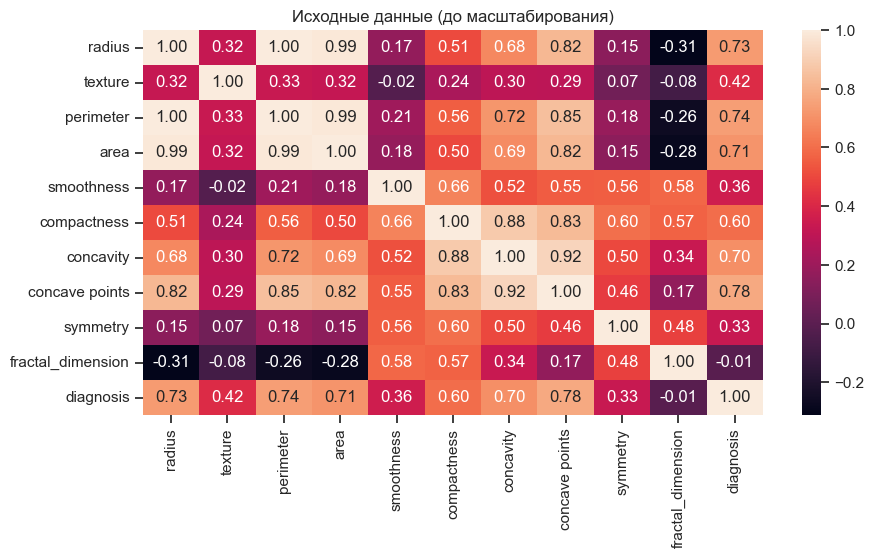

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

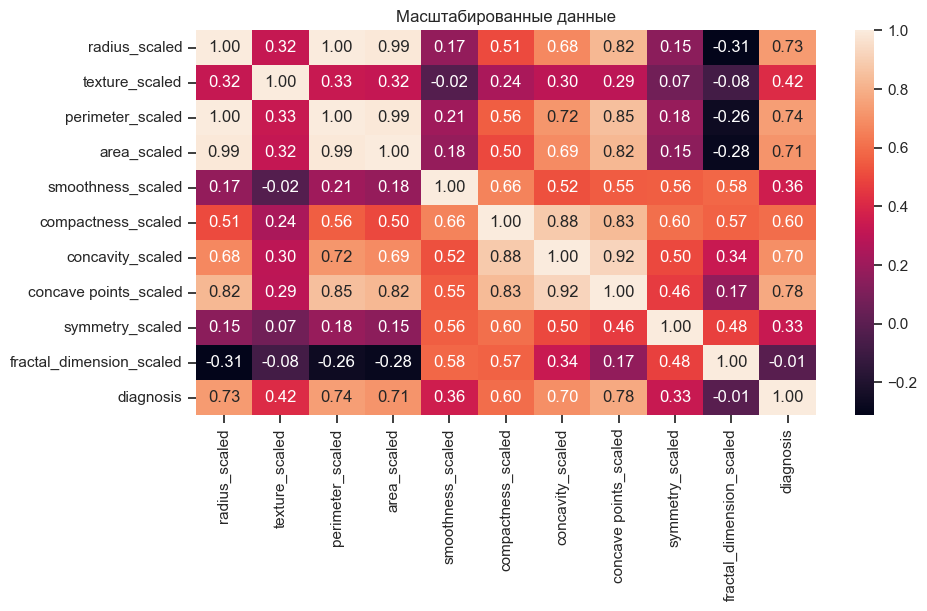

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

- Корреляционные матрицы для исходных и масштабированных данных совпадают.

- Целевой признак классификации "diagnosis" наиболее сильно коррелирует с вогнутыми точками (concave_point = 0.78), периметром (0.74), радиусом (0.73) и площадью (0.71). Эти признаки обязательно следует оставить в модели классификации. Также стоит оставить признак компактность, так как он тожде имеет довольно высокую корреляцию с целевым признаком (0.6).

- Однако, признаки "perimeter", "radius" и "area" имеют корреляцию, близкую по модулю к 1, поэтому все эти признаки не следуют включать в модели. Будем использовать признак "perimeter", так как он лучше чем остальные два коррелирует и с целевым признаком классификации.

- Признаки "concavity" и "concave points" имеют корреляцию, близкую по модулю к 1, поэтому все эти признаки не следуют включать в модели. Будем использовать признак "concave points", так как он лучше чем "concavity" коррелирует и с целевым признаком классификации.
    
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.

Вывод: используем признаки "perimeter" (0.74), "concave_points" (0.78), "compactness" (0.6)

**5. Выбор метрик для последующей оценки качества моделей.**
В качестве метрик для решения задачи классификации будем использовать:
- precision (Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные)

- recall (Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов)

- F1 (Объединяет precision и recall в одну метрику)

- ROC AUC (Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации)

In [31]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [32]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**6. Выбор наиболее подходящих моделей для решения задачи классификации**

In [33]:
# Модели для задачи классификации
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(probability=True),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

**7. Формирование обучающей и тестовой выборок на основе исходного набора данных**

In [34]:
data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split(data[['perimeter', 'concave points', 'compactness']].values, 
    data['diagnosis'].values, test_size=0.5, random_state=1)

**8. Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки**

In [35]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [36]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [37]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(data_X_train, data_Y_train)
    # Предсказание значений
    Y_pred = model.predict(data_X_test)
    # Предсказание вероятности класса "1" для roc auc
    Y_pred_proba_temp = model.predict_proba(data_X_test)
    Y_pred_proba = Y_pred_proba_temp[:,1]
    
    precision = precision_score(data_Y_test, Y_pred)
    recall = recall_score(data_Y_test, Y_pred)
    f1 = f1_score(data_Y_test, Y_pred)
    roc_auc = roc_auc_score(data_Y_test, Y_pred_proba)
    
    clasMetricLogger.df.loc[len(clasMetricLogger.df)] = {'metric': 'precision', 'alg': model_name, 'value': precision}
    clasMetricLogger.df.loc[len(clasMetricLogger.df)] = {'metric': 'recall', 'alg': model_name, 'value': recall}
    clasMetricLogger.df.loc[len(clasMetricLogger.df)] = {'metric': 'f1', 'alg': model_name, 'value': f1}
    clasMetricLogger.df.loc[len(clasMetricLogger.df)] = {'metric': 'roc_auc', 'alg': model_name, 'value': roc_auc}
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))    
    draw_roc_curve(data_Y_test, Y_pred_proba, ax[0])
    cnf_matrix = confusion_matrix(data_Y_test, Y_pred)
    
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')
    plt.show()

Confusion matrix, without normalization
[[166  16]
 [ 22  81]]


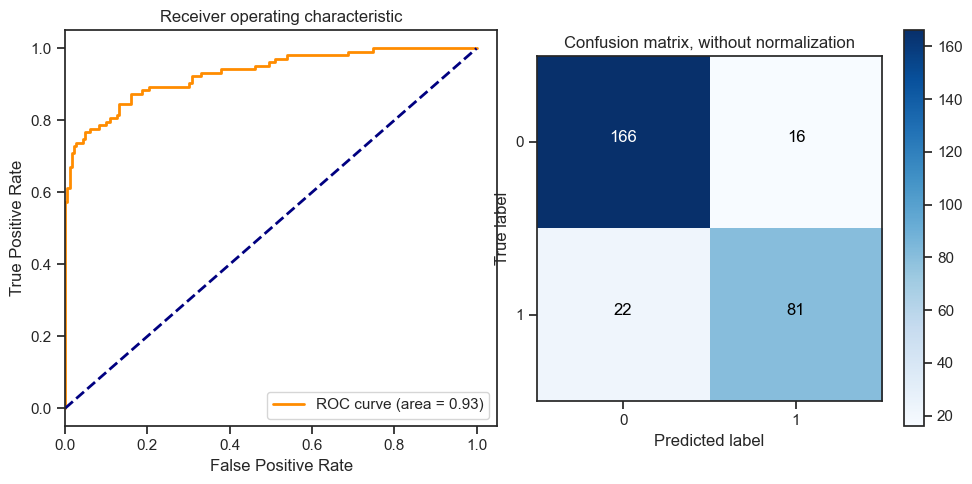

Confusion matrix, without normalization
[[161  21]
 [ 19  84]]


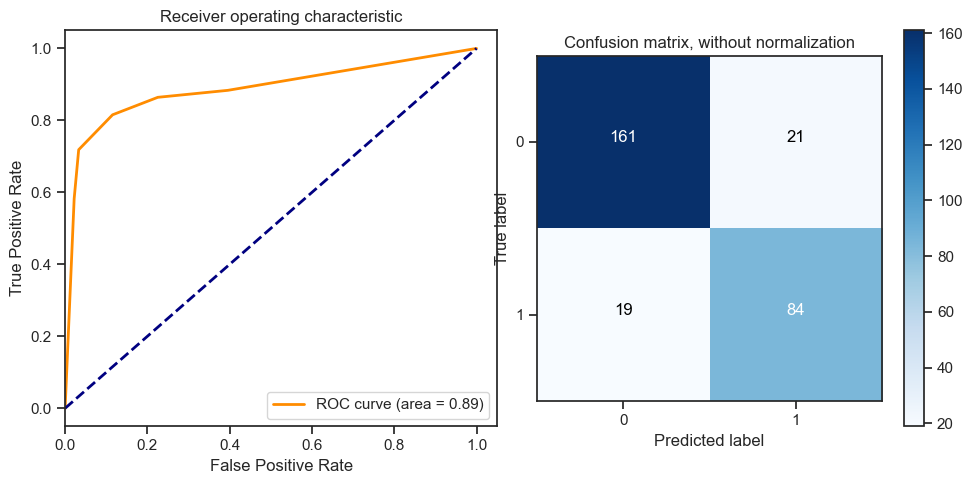

Confusion matrix, without normalization
[[173   9]
 [ 25  78]]


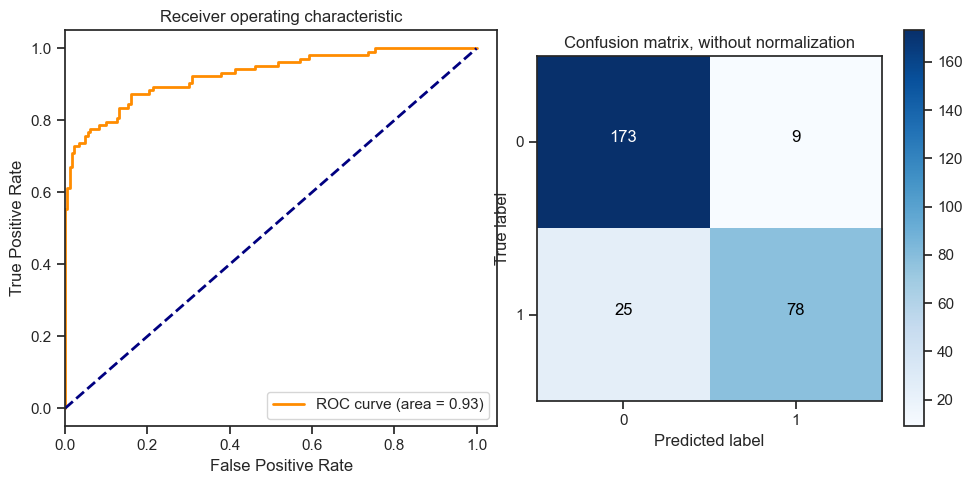

Confusion matrix, without normalization
[[164  18]
 [ 20  83]]


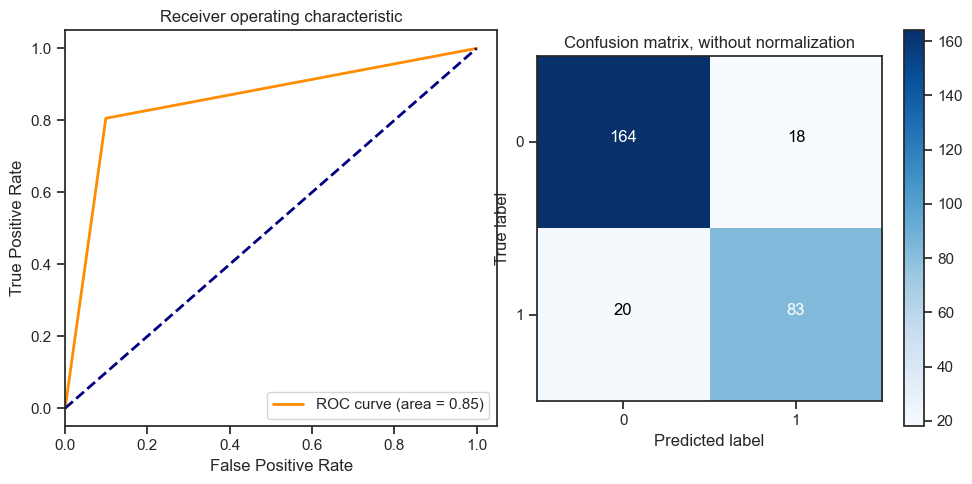

Confusion matrix, without normalization
[[167  15]
 [ 15  88]]


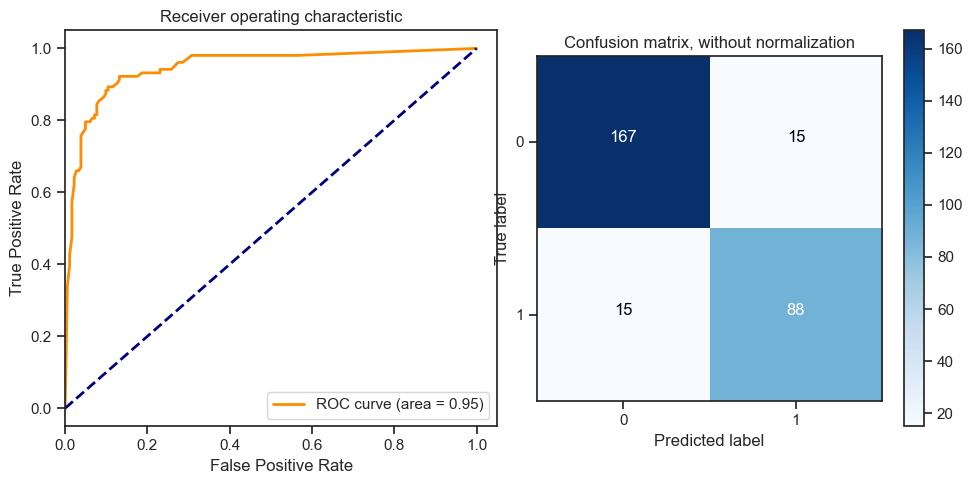

Confusion matrix, without normalization
[[165  17]
 [ 15  88]]


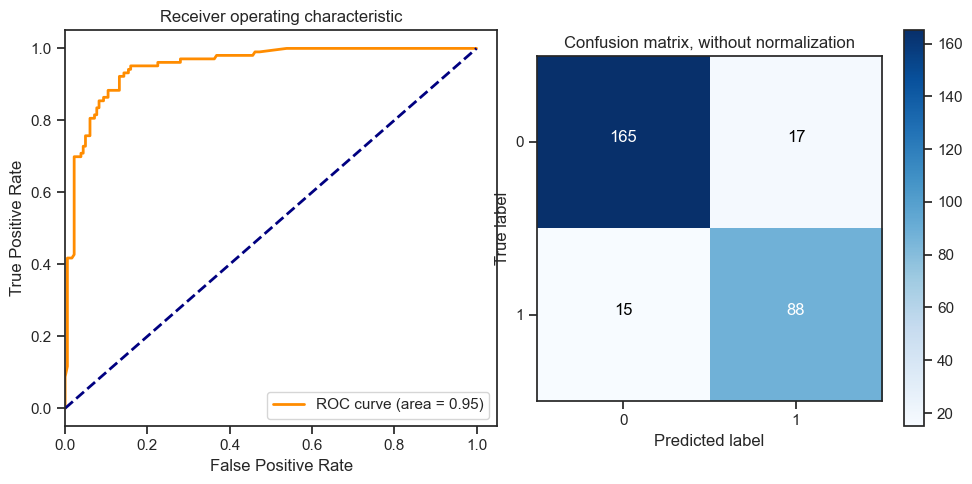

In [38]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

**9. Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы**

In [39]:
n_range_list = list(range(0,200,50))
n_range_list[0] = 1

In [40]:
n_range = np.array(n_range_list)
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([  1,  50, 100, 150])}]

In [41]:
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(data_X_train, data_Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([  1,  50, 100, 150])}],
             scoring='roc_auc')

In [42]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=100)

In [43]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 100}

In [44]:
clf_gs_best_params_txt = str(clf_gs.best_params_['n_neighbors'])
clf_gs_best_params_txt

'100'

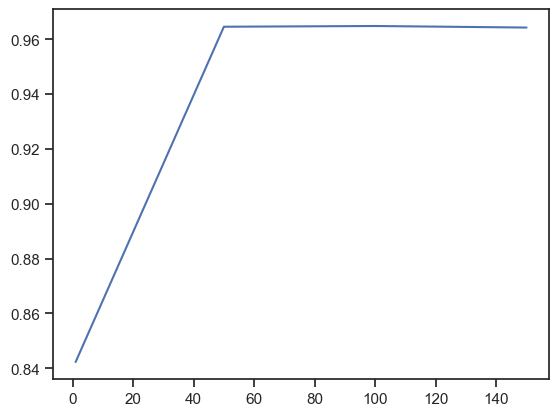

In [45]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

**10. Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей**

In [46]:
clas_models_grid = {'KNN_5':KNeighborsClassifier(n_neighbors=5), 
                    str('KNN_' + clf_gs_best_params_txt):clf_gs.best_estimator_}

Confusion matrix, without normalization
[[161  21]
 [ 19  84]]


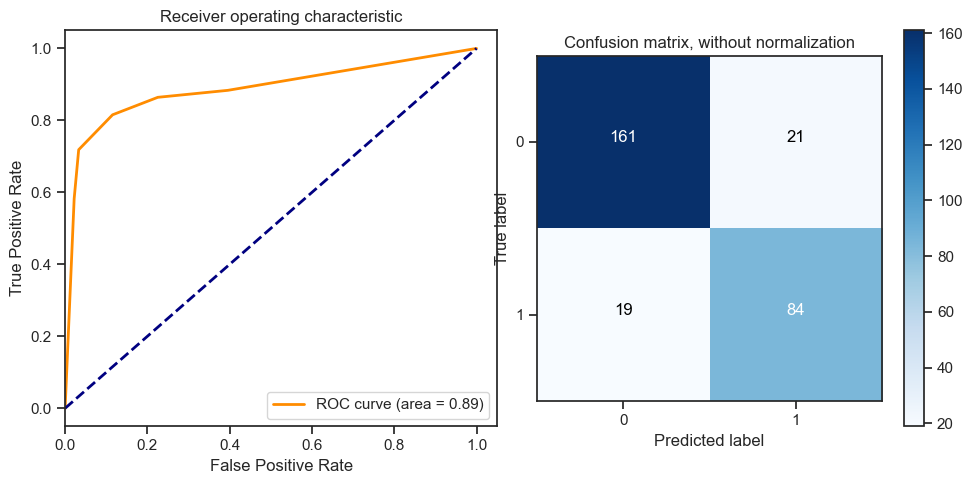

Confusion matrix, without normalization
[[176   6]
 [ 27  76]]


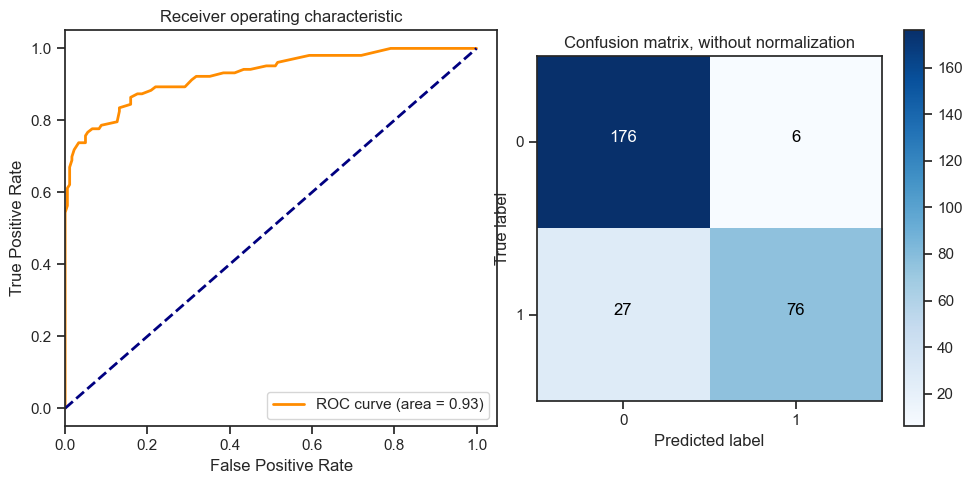

In [47]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

**11. Формирование выводов о качестве построенных моделей на основе выбранных метрик**

Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

In [48]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

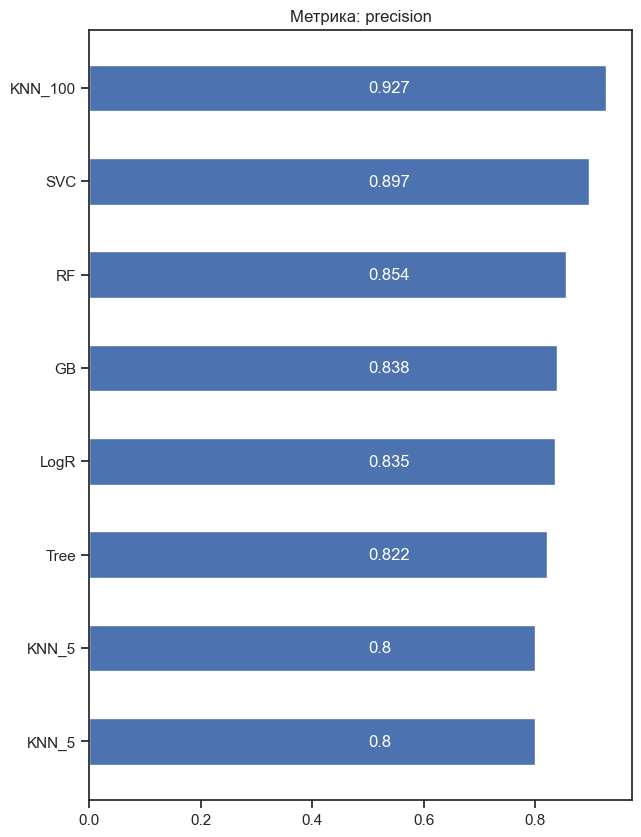

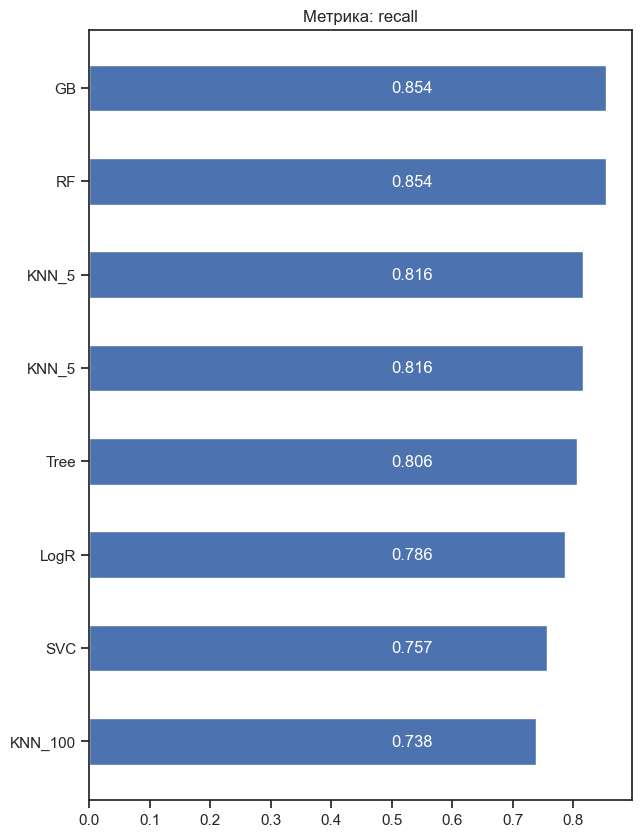

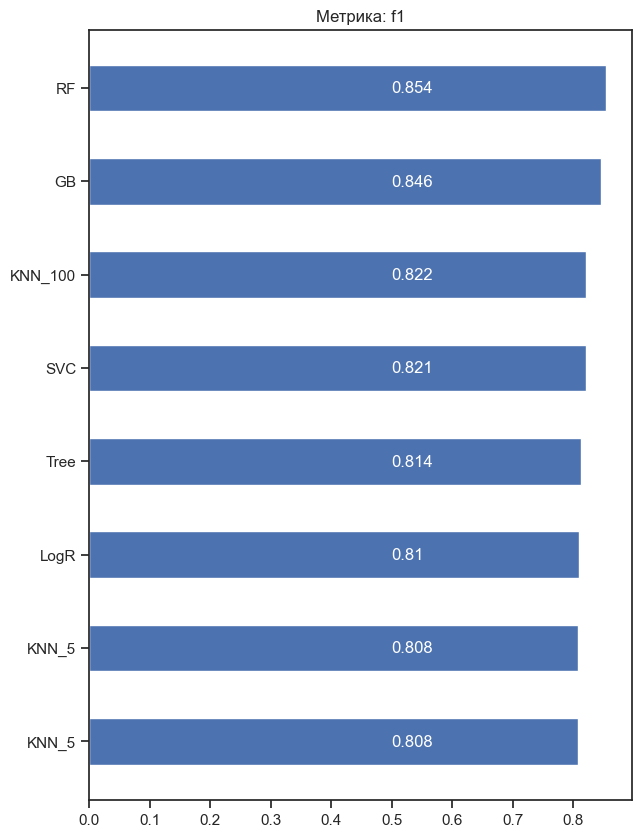

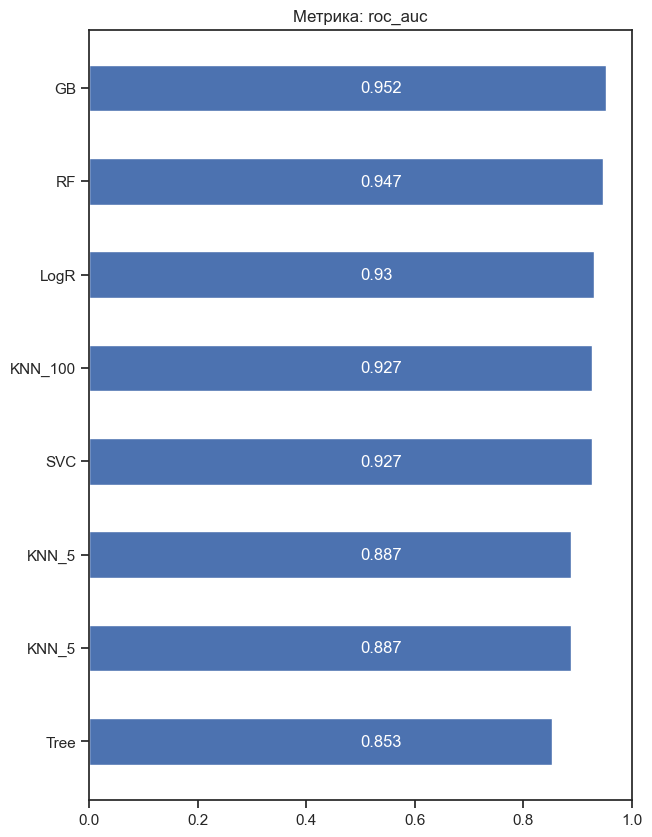

In [49]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 10))

Вывод: в двух метриках из четырех используемых лучшей оказалась модель градиентного бустинга. В метрике F1 лучшей оказалась модель Случайного леса, а в метрике Precision - модель ближайших соседей.